# Classical Autoencoder

In this notebook we train a very simple classical Convolutional Autoencoder on the 12x12 version of the Quark Gluon dataset.
We build the model to have a comparable amount of parameters to the hybrid and quantum model (in this case ~3000 parameters)

## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from hep_VQAE import CAE as cae
import h5py
from sklearn.model_selection import train_test_split
from hep_VQAE import utils as ut

import tensorflow_addons as tfa

2022-09-23 12:00:34.668130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-23 12:00:34.668170: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data

load the 12x12 version of the dataset

In [2]:
f = h5py.File("../data/small_quark_gluon_12","r")

In [3]:
x_train = f.get('X')
y_train = f.get('y')

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train[:], y_train[:], test_size=0.2, shuffle=True)

like in the other notebooks we normalize the images by dividing every image by its largest pixel value. In addition we split the quarks (1) and gluons (0).

In [5]:
x_train_ones = x_train[y_train==1]
x_train_ones = x_train_ones.reshape(x_train_ones.shape + (1,))
x_train = x_train[y_train==0]
x_train = x_train.reshape(x_train.shape + (1,))

div1 = np.max(x_train, axis=(1,2)).reshape((x_train.shape[0],1,1,1))
div1[div1 == 0] = 1
x_train = x_train / div1
div2 = np.max(x_train_ones, axis=(1,2)).reshape((x_train_ones.shape[0],1,1,1))
div2[div2 == 0] = 1
x_train_ones = x_train_ones / div2

x_val_ones = x_val[y_val==1]
x_val_ones = x_val_ones.reshape(x_val_ones.shape + (1,))
x_val = x_val[y_val==0]
x_val = x_val.reshape(x_val.shape + (1,))

div1 = np.max(x_val, axis=(1,2)).reshape((x_val.shape[0],1,1,1))
div1[div1 == 0] = 1
x_val = x_val / div1
div2 = np.max(x_val_ones, axis=(1,2)).reshape((x_val_ones.shape[0],1,1,1))
div2[div2 == 0] = 1
x_val_ones = x_val_ones / div2


x_test = x_val
x_test_ones = x_val_ones

limit the data to make it comparable to quantum models

In [6]:
x_train_ones = x_train_ones[:10000]
x_train = x_train[:10000]
x_val = x_val[:1200]
x_val_ones = x_val_ones[:1200]

## Model

We load the 12x12 Autoencoder model form the package with a latent space size of 20.

In [7]:
model = cae.Convolutional_Autoencoder_12x12(20)

2022-09-23 12:00:37.620288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-23 12:00:37.620326: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-23 12:00:37.620350: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-09-23 12:00:37.620595: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.build(input_shape=(1,12,12,1))

This is what the model looks like:

In [9]:
model.summary()

Model: "convolutional__autoencoder_12x12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 21)                2057      
                                                                 
 sequential_1 (Sequential)   (1, 12, 12, 1)            1349      
                                                                 
Total params: 3,406
Trainable params: 3,406
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 12, 4)         68        
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 4)         260       
                                                                 
 average_pooling2d (AverageP  (None, 6, 6, 4)          0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 2)           130       
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 2)           66        
                                                                 
 flatten (Flatten)           (None, 72)                0         
                                                        

In [11]:
model.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (1, 36)                   792       
                                                                 
 reshape (Reshape)           (1, 6, 6, 1)              0         
                                                                 
 conv2d_4 (Conv2D)           (1, 6, 6, 2)              34        
                                                                 
 conv2d_5 (Conv2D)           (1, 6, 6, 2)              66        
                                                                 
 up_sampling2d (UpSampling2D  (1, 12, 12, 2)           0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (1, 12, 12, 4)            132       
                                                      

## Training

I use adamw as optimizer

In [12]:
learning_rate = 0.0001
weight_decay = 0.00001
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

In [13]:
model.compile(loss='binary_crossentropy', optimizer=optimizer)

The auc callback will track the AUC on the anomaly tagging of the validation data throughout the training

In [14]:
auc_call = cae.AucCallback(model, x_val_ones, x_val)

We use early stopping on the validation loss. Training can take some time as we have to train for a lot of epochs.

In [15]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=5e-6)
hist = model.fit(x_train_ones,x_train_ones,epochs=1200,validation_data=(x_val_ones,x_val_ones),callbacks=[es,auc_call], batch_size=30)

Epoch 1/1200
334/334 [==============================] - 5s 12ms/step - loss: 0.4153 - val_loss: 0.1243
Epoch 2/1200
334/334 [==============================] - 3s 10ms/step - loss: 0.0980 - val_loss: 0.0788
Epoch 3/1200
334/334 [==============================] - 4s 11ms/step - loss: 0.0714 - val_loss: 0.0658
Epoch 4/1200
334/334 [==============================] - 3s 10ms/step - loss: 0.0641 - val_loss: 0.0619
Epoch 5/1200
334/334 [==============================] - 4s 11ms/step - loss: 0.0614 - val_loss: 0.0601
Epoch 6/1200
334/334 [==============================] - 4s 11ms/step - loss: 0.0599 - val_loss: 0.0590
Epoch 7/1200
334/334 [==============================] - 4s 11ms/step - loss: 0.0590 - val_loss: 0.0582
Epoch 8/1200
334/334 [==============================] - 4s 11ms/step - loss: 0.0583 - val_loss: 0.0576
Epoch 9/1200
334/334 [==============================] - 4s 11ms/step - loss: 0.0578 - val_loss: 0.0572
Epoch 10/1200
334/334 [==============================] - 3s 10ms/step - l

## Evaluation

We can check the loss and auc history

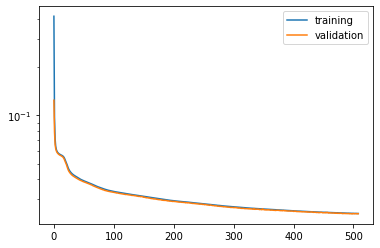

In [16]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

Text(0, 0.5, 'auc')

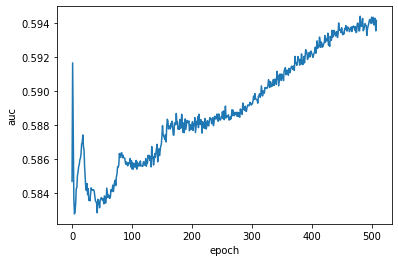

In [17]:
plt.plot(auc_call.hist)
plt.xlabel("epoch")
plt.ylabel("auc")

and evaluate the reconstruction abilities.
First on the data it was trained on

Collapse_metric: 0.944
Average EMD: 2.4
ssim: 0.889
MAE: 0.00925
normalized MAE: 0.00465


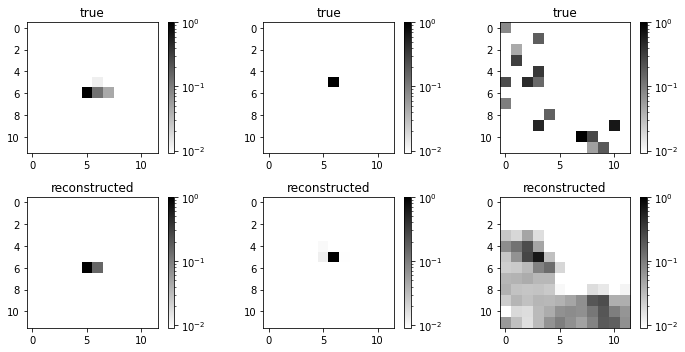

In [18]:
recon = model.predict(x_val_ones)

ut.eval_recon(x_val_ones, recon, lognorm=True)

And now on the anomalous signal samples.

Collapse_metric: 0.926
Average EMD: 2.99
ssim: 0.86
MAE: 0.0118
normalized MAE: 0.00522


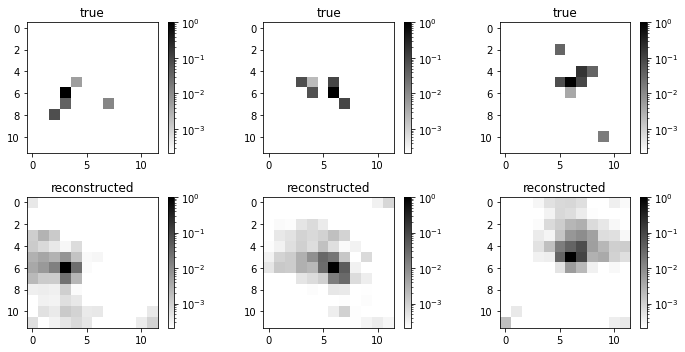

In [19]:
recon = model.predict(x_val)

ut.eval_recon(x_val, recon, lognorm=True)

This is again the anomaly tagging performance

Median background: 0.017
Median signal: 0.0245
Maximum accuracy: 0.575
AUC: 0.5942


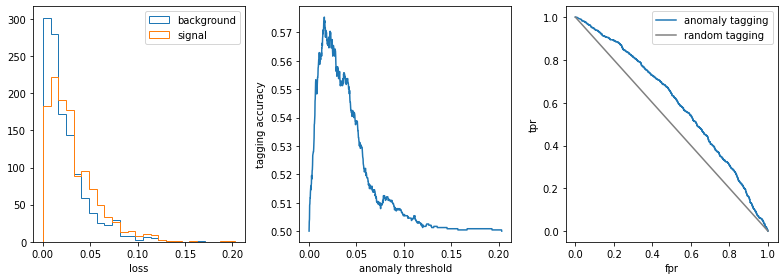

In [20]:
recon = model.predict(x_val)
recon_1 = model.predict(x_val_ones)

ut.eval_tagging(x_val_ones, recon_1, x_val, recon)